In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import os
import sys
import logging

In [65]:
adata_rbpj = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Rbpj_v1.h5ad"
adata_ets1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Ets1_v1.h5ad"
adata_ikzf1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Ikzf1_v1.h5ad"
out_dir = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs"

In [66]:
from os.path import basename
import stream as st
adata_rbpj = st.read(file_name=adata_rbpj, workdir=out_dir)

# import scanpy as sc
# adata_rbpj = sc.read(adata_rbpj)

Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs


In [67]:
adata_rbpj

AnnData object with n_obs × n_vars = 9072 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'cell_cluster_colors', 'condition_colors', 'orig.ident_colors', 'workdir'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [68]:
adata_rbpj_ntc = adata_rbpj[adata_rbpj.obs.condition == "NTC"]

#### Add obs (condition and cluster label)

In [ ]:
# # the number to label mapping is the same for all TFs

# cell_type_annotation = {    "Tpex":[0,1],
#                             "Tex": [2,3],}

# cell_type_annotation_reverse = {}
# for i in set(adata_ikzf1.obs.celltype2):
#     for k in cell_type_annotation:
#         if int(i) in cell_type_annotation[k]:
#             cell_type_annotation_reverse[i] = k
# adata_ikzf1.obs["cell_cluster"] = [cell_type_annotation_reverse[i] for i in adata_ikzf1.obs.celltype2]

In [ ]:
# condition_annotation = {
#     "KO": ['S2_sgRbpj', 'S3_sgEts1', 'S4_sgEts1', 'S2_sgIkzf1', 'S4_sgIkzf1'],
#     "NTC": ['S4_sgNTC', 'S1_NTC', 'S2_NTC', 'S1_Spike', 'S3_Spike']
# }
# # Invert the dictionary
# sample_to_condition = {}
# for condition, samples in condition_annotation.items():
#     for sample in samples:
#         sample_to_condition[sample] = condition

# # Now map it to your adata object
# adata_ikzf1.obs["condition"] = adata_ikzf1.obs["orig.ident"].map(sample_to_condition)

In [69]:
colormap = {'Tpex': 'darkblue', 'Tex': 'lightpink'}

In [70]:
categories = adata_rbpj_ntc.obs['cell_cluster'].cat.categories
display(categories)
display(adata_rbpj_ntc.obs['cell_cluster'].value_counts())

Index(['Tex', 'Tpex'], dtype='object')

Tpex    4156
Tex     1019
Name: cell_cluster, dtype: int64

In [71]:
# First, make sure the colors are in the same order as the categories
colors = [colormap[cat] for cat in categories]

# Set the colors in adata.uns
adata_rbpj_ntc.uns['cell_cluster_colors'] = colors

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


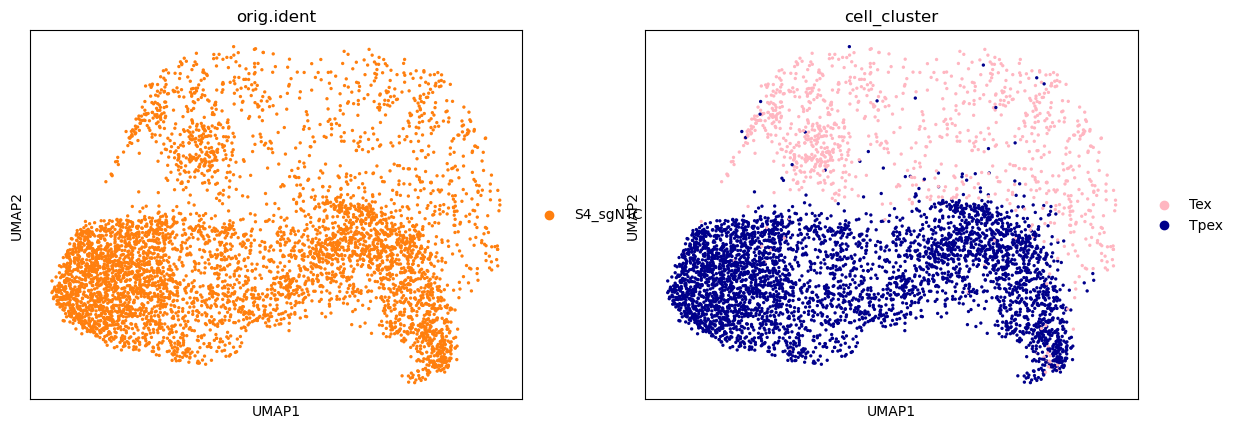

In [ ]:
#sc.pl.umap(adata_rbpj_ntc, color=['orig.ident', 'cell_cluster'])

# Run stream dim reduction

In [72]:
st.cal_qc(adata_rbpj_ntc,assay='rna')

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/stream/core.py:427: RuntimeWarning: divide by zero encountered in true_divide
  adata.obs['pct_mt'] = n_counts_mt/n_counts


In [73]:
st.filter_cells(adata_rbpj_ntc,min_n_features= 100)
st.filter_features(adata_rbpj_ntc,min_n_cells = 5)

filter cells based on min_n_features
after filtering out low-quality cells: 
4772 cells, 2000 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
4772 cells, 1762 genes


In [74]:
###Normalize gene expression based on library size  
st.normalize(adata_rbpj_ntc,method='lib_size')
###Logarithmize gene expression 
st.log_transform(adata_rbpj_ntc)
###Remove mitochondrial genes 
st.remove_mt_genes(adata_rbpj_ntc)

remove mitochondrial genes:
['mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd6', 'mt-Cytb']


/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/stream/core.py:748: RuntimeWarning: invalid value encountered in log2
  adata.X = np.log2(adata.X+1)/np.log2(base)


In [75]:
import numpy as np
import scipy.sparse as sp

X = adata_rbpj_ntc.X

In [76]:
if sp.issparse(X):
    data = X.data
    data[np.isnan(data)] = 0
    X.eliminate_zeros()
else:
    np.nan_to_num(X, copy=False)  # in-place: NaN->0, inf->large finite

In [77]:
n_nans = np.isnan(X.data).sum() if sp.issparse(X) else np.isnan(X).sum()
display(n_nans)
display(adata_rbpj_ntc.X.size)

0

8384404

In [78]:
display(adata_rbpj_ntc.X)

array([[12.12361  , 10.877287 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [11.579858 , 12.025382 ,  7.2471066, ...,  6.4329805,  6.326052 ,
         6.224569 ],
       [11.215726 , 10.6903925,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [11.115035 ,  0.       ,  6.785712 , ...,  5.974314 ,  5.8678727,
         5.7668853],
       [10.476264 , 10.921643 ,  6.153848 , ...,  5.347915 ,  5.2424436,
         5.142445 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

352 variable genes are selected


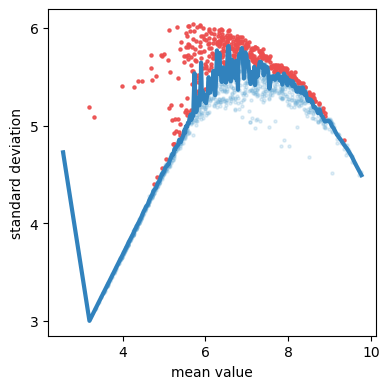

In [79]:
# # Setting var_genes if you need to select top 3k genes from a list of more than 3k genes
st.select_variable_genes(adata_rbpj_ntc,loess_frac=0.01,percentile=80)

In [80]:
# # 'var_genes' vs 'all' : use top % or all genes from .var ; if using all make sure the adata is subsetted to only the highly variable genes
# # n_components = Number of branches present in your biological differentation
st.dimension_reduction(adata_rbpj_ntc,method='se',feature='var_genes',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

feature var_genes is being used ...
64 cpus are being used ...


In [82]:
# # Order the cell states for plotting (colors need to be categorical)
adata_rbpj_ntc.obs['cell_cluster'] = pd.Categorical(
    adata_rbpj_ntc.obs['cell_cluster'],
    categories=['Tpex', 'Tex'],
    ordered=True
)
# Create a new column in adata.obs for colors
adata_rbpj_ntc.obs['cell_cluster_colors'] = adata_rbpj_ntc.obs['cell_cluster'].map(colormap)

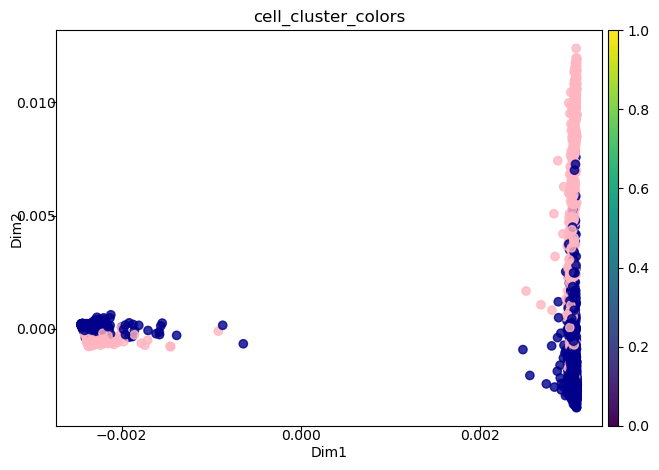

In [83]:
st.plot_dimension_reduction(adata_rbpj_ntc, color=['cell_cluster_colors'], n_components=2)